In [2]:
from aptamer_transformer.model import *
from aptamer_transformer.factories_model_loss import *
from aptamer_transformer.data_utils import *
from aptamer_transformer.dataset import *

import torch
import torch.nn.functional as F
from torch import optim

import seaborn as sns
import yaml
import xgboost as xgb
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

2024-01-30 14:07:03.883560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 14:07:03.883627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 14:07:04.024628: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 14:07:04.136390: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-30 14:07:29.166403: W tensorflow/comp

In [3]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

device = torch.device("cuda:0")  
cfg.update({
    'device': device,
})

dna_dataset = load_dataset(cfg)

model = get_model(cfg).to(cfg['device'])


In [ ]:
dna_dataset

In [4]:
cls_embeddings_list = []
all_loader = DataLoader(dna_dataset, batch_size=100)

with torch.no_grad():
    model.eval()
    for data in all_loader:
        model_inputs = data[:-1]
        model_targets = data[-1]

        tokenized_seqs = model_inputs[0].to(cfg['device'])
        attn_mask = model_inputs[1].bool()
        attn_mask = ~attn_mask.to(cfg['device'])
        logits, embbed = model(tokenized_seqs, attn_mask=attn_mask)

        cls_embeddings = embbed[:, 0, :]
        cls_embeddings_list.append(cls_embeddings.cpu())

# Concatenate all CLS embeddings
cls_embeddings_all = torch.cat(cls_embeddings_list, dim=0)


In [2]:
cfg = read_cfg('../aptamer_transformer/config.yaml')

device = torch.device("cuda:1")  
cfg.update({
    'device': device,
})

dna_dataset = load_dataset(cfg)

regression_model = get_model(cfg).to(cfg['device'])

In [4]:
regression_score = []
regression_cls_embbedings = []

all_loader = DataLoader(dna_dataset, batch_size=100)

with torch.no_grad():
    regression_model.eval()
    for data in all_loader:
        model_inputs = data[:-1]
        model_targets = data[-1]

        tokenized_seqs = model_inputs[0].to(cfg['device'])
        attn_mask = model_inputs[1].bool()
        attn_mask = ~attn_mask.to(cfg['device'])
        pred, embbed = regression_model(tokenized_seqs, attn_mask=attn_mask)

        cls_embeddings = embbed[:, 0, :]
        regression_cls_embbedings.append(cls_embeddings.cpu())
        
        regression_score.append(pred.cpu())

# Concatenate all CLS embeddings
regression_cls_embbedings = torch.cat(regression_cls_embbedings, dim=0)


In [16]:
z = np.concatenate([val.detach().cpu().numpy().squeeze() for val in regression_score])

z.shape

(513695,)

In [30]:
z.max()

2.0519967

In [5]:
U,S,V = torch.pca_lowrank(regression_cls_embbedings, q=2, center=True, niter=2)

In [21]:
x = U[:,0].detach().cpu().numpy()
y = U[:,1].detach().cpu().numpy()

In [38]:
x, y = embedding[:, 0], embedding[:, 1]
z = z[:100000]

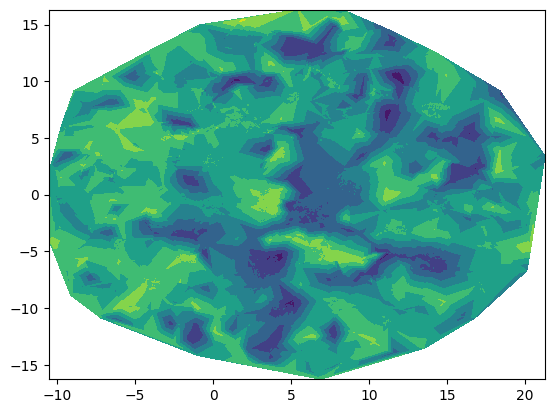

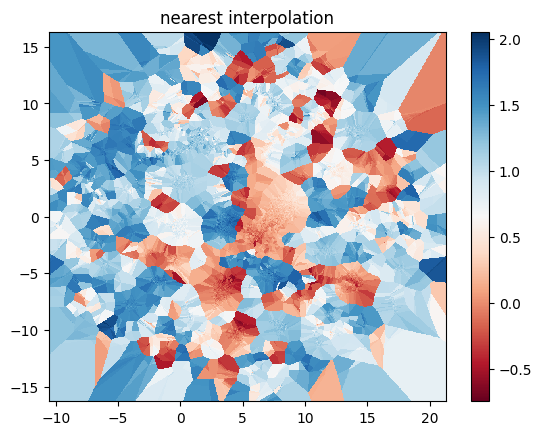

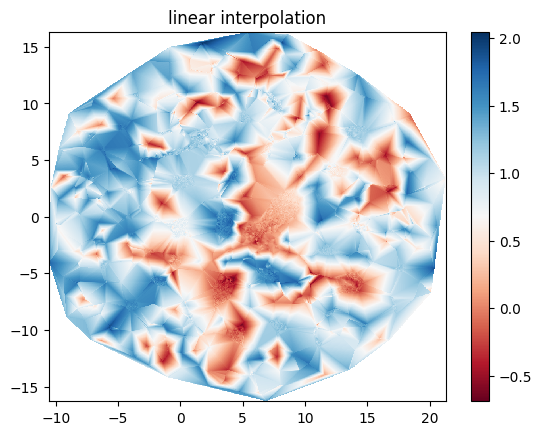

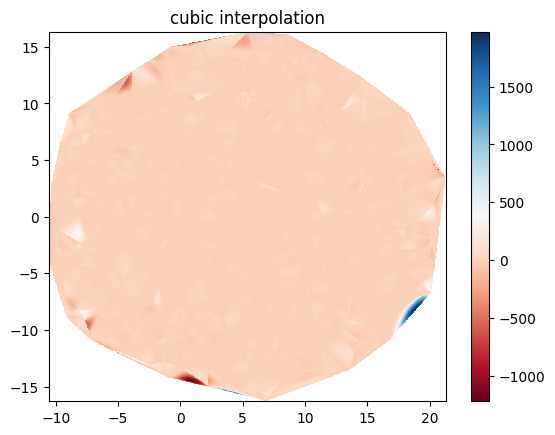

In [39]:
import scipy.interpolate

plt.tricontourf(x, y, z)
xy = np.column_stack([x.flat, y.flat])
grid_x, grid_y = np.mgrid[x.min():x.max():1000j, y.min():y.max():1000j]
for method in ['nearest','linear','cubic'] :
    plt.figure()
    grid_z = scipy.interpolate.griddata(xy,z,(grid_x, grid_y), method=method)
    # [pcolormesh with missing values?](https://stackoverflow.com/a/31687006/395857)
    import numpy.ma as ma
    plt.pcolormesh(grid_x, grid_y, ma.masked_invalid(grid_z), cmap='RdBu', vmin=np.nanmin(grid_z), vmax=np.nanmax(grid_z))
    plt.title('{0} interpolation'.format(method))
    plt.colorbar()
    # plt.savefig('heatmap_interpolation_{0}.png'.format(method), dpi=300)
    plt.show()

In [15]:
cls_embeddings_np = cls_embeddings_all.detach().cpu().numpy()
cls_embeddings_np[:1000, :].shape

(1000, 120)

In [40]:
import umap
import matplotlib.pyplot as plt

# Assuming cls_embeddings_np is your numpy array
regression_cls_embbedings_np = regression_cls_embbedings.detach().cpu().numpy()
reducer = umap.UMAP()
embedding = reducer.fit_transform(regression_cls_embbedings_np)

# Plotting the reduced data (for 2D UMAP)
plt.scatter(embedding[:, 0], embedding[:, 1], s=1)
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('2D UMAP of CLS Embeddings')
plt.show()


In [36]:
embedding.shape

(30000, 2)

In [17]:
embedding

array([[11.690519 , 15.553945 ],
       [ 8.773387 ,  0.9815102],
       [12.018294 , 15.568915 ],
       ...,
       [13.198822 ,  6.740809 ],
       [13.268667 ,  6.7431602],
       [ 5.7334194, 10.253307 ]], dtype=float32)